## Electricity Pricing Time Series Analysis


### Problem Statement:
Electricity prices fluctuate due to various factors such as demand, supply conditions, and external influences like weather and market trends. This project aims to explore whether future electricity prices can be predicted using a time series analysis approach. By leveraging historical data, the goal is to develop a predictive model that can forecast price movements. 

### Data Preparation

This code performs several steps to prepare and visualize a time series dataset related to electricity prices. First, it imports the necessary libraries for data manipulation (`pandas`, `numpy`), visualization (`seaborn`, `matplotlib`), and data scaling (`MinMaxScaler`). The dataset is then loaded from a CSV file (`time_series_60min_singleindex.csv`), with the `utc_timestamp` and `cet_cest_timestamp` columns parsed as datetime objects and set as the index. The relevant columns for features and the target variable are selected, and the DataFrame is filtered to keep only the necessary data. Below includes a plot to visualize the trend of electricity prices over time and prints out some basic statistics for the target price column.


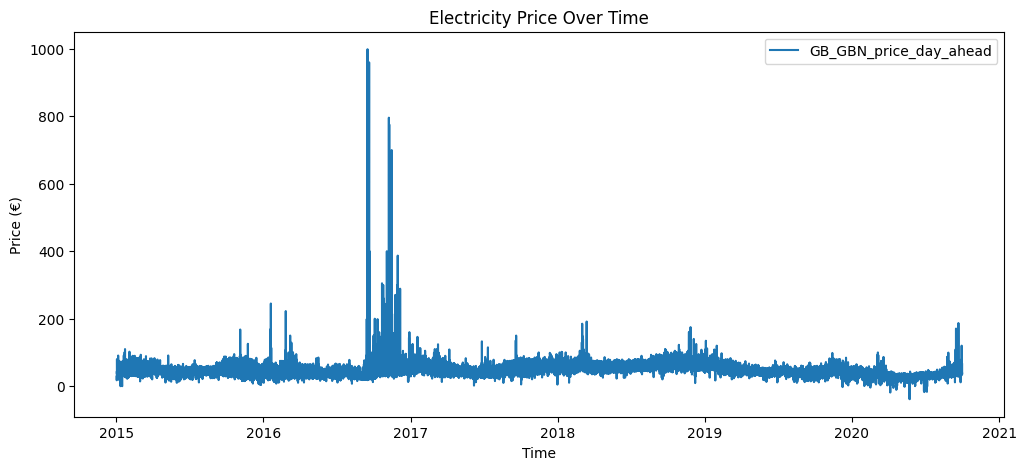

       GB_GBN_price_day_ahead
count            50290.000000
mean                43.432055
std                 18.830075
min                -38.800000
25%                 33.880000
50%                 41.010000
75%                 50.400000
max                999.000000


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv('time_series_60min_singleindex.csv', parse_dates=['utc_timestamp', 'cet_cest_timestamp'], index_col='utc_timestamp')

# Feature columns only 
feature_columns = [
    'GB_GBN_load_actual_entsoe_transparency',
    'GB_GBN_load_forecast_entsoe_transparency',
    'GB_GBN_solar_generation_actual',
    'GB_GBN_wind_offshore_generation_actual',
    'GB_GBN_wind_onshore_generation_actual'
]

target_column = [
    'GB_GBN_price_day_ahead'
]

# Filter df
df = df[feature_columns + target_column]

# Visualize the price trends
plt.figure(figsize=(12, 5))
plt.plot(df.index, df[target_column], label="GB_GBN_price_day_ahead")
plt.xlabel("Time")
plt.ylabel("Price (€)")
plt.title("Electricity Price Over Time")
plt.legend()
plt.show()

price_stats = df[target_column].describe()
print(price_stats)


### Preprocessing
This code prepares a time series dataset by filling missing values with forward-fill to ensure continuity in the data. It normalises feature columns using a MinMaxScaler to scale all values between 0 and 1, which helps models perform better by eliminating bias due to differing feature scales. Lag features are created by shifting the target variable (1 to 24 hours) to capture temporal dependencies and trends. The lag features are then normalised to maintain consistency in scaling. Finally, rows with NaN values, caused by the lagging process, are dropped.

In [2]:
from sklearn.preprocessing import MinMaxScaler

# Fill missing values with forward-fill method
df.ffill(inplace=True)

# Normalize feature columns (scaling values between 0 and 1)
scaler = MinMaxScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Create lag features (previous 24 hours as input)
for i in range(1, 25):  
    df[f'lag_{i}'] = df[target_column].shift(i)

# Normalize lag features (scale after creating the lag)
df_lag_features = df[[f'lag_{i}' for i in range(1, 25)]]
df[df_lag_features.columns] = scaler.fit_transform(df_lag_features)

# Drop NaN values caused by shifting (lagging creates NaNs)
df.dropna(inplace=True)

### Fitting the Model
This code prepares a time series dataset by splitting it into training and testing sets, then separates features and the target variable. The data is reshaped for the LSTM model, which requires a 3D format. An LSTM model is built with two layers, using L2 regularisation and Dropout to prevent overfitting. The model is compiled with the Adam optimiser and MSE loss function. Early stopping is applied to halt training if the validation loss plateaus. The model is trained, and loss curves are plotted to monitor performance and prevent overfitting. 

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Split into features (X) and target (y)
# Drop any non-scaled columns from the df
X_train, y_train = train.drop(columns=target_column), train[target_column]
X_test, y_test = test.drop(columns=target_column), test[target_column]

# Convert to NumPy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

features = X_train.shape[1]

# Reshape data for LSTM (3D shape: [samples, timesteps, features])
X_train = X_train.reshape((X_train.shape[0], 1, features))
X_test = X_test.reshape((X_test.shape[0], 1, features))

# Define LSTM Model with stronger regularisation
model = Sequential([
    Input(shape=(1, features)),  # Define the input shape using Input
    LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose = 0)


### Fit & Visualisation 
The performance of a time series model is evaluated by calculating the Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) between the predicted and actual values. It then visualises the actual and predicted electricity prices over time using an interactive Plotly graph. The plot helps assess how well the model captures price trends, providing a clear comparison between actual and predicted values, which is essential for evaluating and improving time series forecasting models.

(10071, 1) (10071, 1)
Mean Absolute Error: 3.8427831731194386
Root Mean Squared Error: 5.676930117129195


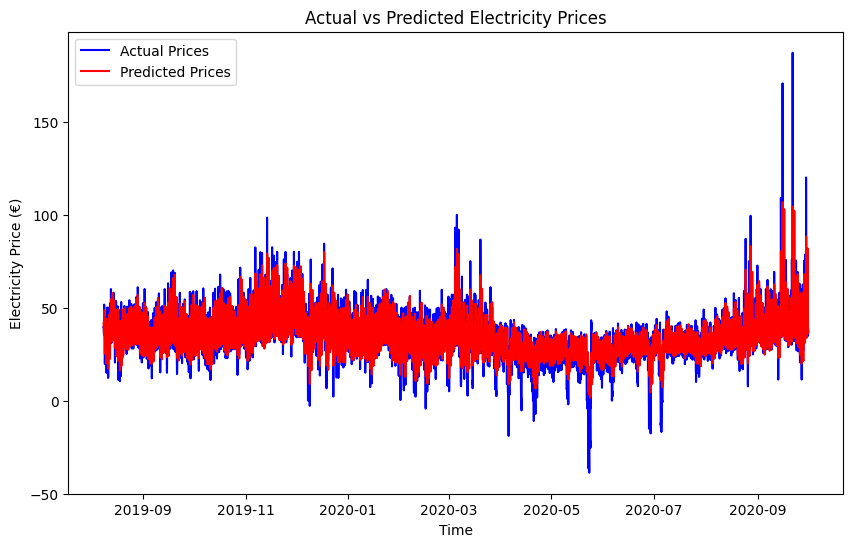

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test, verbose=0)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(y_pred.shape, y_test.shape)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

# Ensure that the time index matches for both actual and predicted prices
time_index = df.index[-len(y_test):]  # Correct length based on y_test

# Plotting the actual and predicted prices
plt.figure(figsize=(10, 6))

# Plot actual prices
plt.plot(time_index, y_test.flatten(), label="Actual Prices", color='blue')

# Plot predicted prices
plt.plot(time_index, y_pred.flatten(), label="Predicted Prices", color='red')

# Adding title and labels
plt.title("Actual vs Predicted Electricity Prices")
plt.xlabel("Time")
plt.ylabel("Electricity Price (€)")
plt.legend()

# Show the plot
plt.show()


### Conclusion
Given that the model sometimes struggles to predict the magnitude of outliers, it suggests that while it may identify price spikes, it isn't always accurate in forecasting their size. This could be due to the model's difficulty in predicting extreme fluctuations, which are often influenced by unpredictable external factors. To improve performance, incorporating additional features such as weather data, market events, or demand changes, or exploring more advanced models like ensemble methods or attention mechanisms, could help the model better anticipate the scale of these outliers and improve its overall accuracy.